In [1]:
import json
import os

def load_json(file_path):
    """
    Load parsed query plans from a JSON file.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        list: A list of parsed query plans.
    """
    with open(file_path, 'r') as f:
        plans = json.load(f)
    return plans

# Load training and validation plans
data_dir = '/home/wuy/DB/pg_mem_data'
dataset = 'tpch_sf1'
train_json_file = os.path.join(data_dir, dataset, 'zsce', 'train_plans.json')
val_json_file = os.path.join(data_dir, dataset, 'zsce', 'val_plans.json')
test_json_file = os.path.join(data_dir, dataset, 'zsce', 'test_plans.json')

# Load training and validation plans
train_plans = load_json(train_json_file)
val_plans = load_json(val_json_file)
test_plans = load_json(test_json_file)
print(f"number of training plans: {len(train_plans)}")
print(f"number of validation plans: {len(val_plans)}")
print(f"number of test plans: {len(test_plans)}")

number of training plans: 3
number of validation plans: 3
number of test plans: 3


In [2]:
from collections import defaultdict
import numpy as np

def extract_features(parsed_plan):
    """
    Extract features from a parsed PostgreSQL query plan.

    Args:
        parsed_plan (dict): The parsed query plan.

    Returns:
        dict: A dictionary of aggregated features.
    """
    features = defaultdict(float)
    op_counts = defaultdict(int)
    numerical_features = defaultdict(list)
    max_depth = 0

    def traverse(node, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)

        params = node.get('plan_parameters', {})
        op_name = params.get('op_name', 'Unknown')
        op_counts[op_name] += 1

        # Collect numerical features
        numerical_features['est_startup_cost'].append(params.get('est_startup_cost', 0.0))
        numerical_features['est_cost'].append(params.get('est_cost', 0.0))
        numerical_features['est_card'].append(params.get('est_card', 0.0))
        numerical_features['est_width'].append(params.get('est_width', 0.0))
        numerical_features['workers_planned'].append(params.get('workers_planned', 0.0))
        numerical_features['est_children_card'].append(params.get('est_children_card', 0.0))

        # Recursively traverse children
        for child in node.get('children', []):
            traverse(child, depth + 1)

    traverse(parsed_plan)

    # Aggregate operation counts
    for op, count in op_counts.items():
        features[f'op_count_{op}'] = count

    # Aggregate numerical features
    for feature, values in numerical_features.items():
        features[f'{feature}_sum'] = sum(values)
        features[f'{feature}_mean'] = np.mean(values) if values else 0.0
        features[f'{feature}_max'] = max(values) if values else 0.0
        features[f'{feature}_min'] = min(values) if values else 0.0

    # Add structural features
    features['tree_depth'] = max_depth
    features['num_nodes'] = len(numerical_features['est_cost'])

    return features


In [3]:
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def prepare_dataset(plans):
    """
    Prepare a dataset by extracting features and collecting labels.

    Args:
        plans (list): A list of parsed query plans.

    Returns:
        pd.DataFrame: DataFrame containing features.
        pd.Series: Series containing labels (peak memory).
    """
    feature_dicts = []
    labels = []

    for plan in tqdm(plans['parsed_plans']):
        features = extract_features(plan)
        feature_dicts.append(features)
        labels.append(plan.get('peakmem', 0.0))  # Assuming 'peakmem' is the target

    # Convert to DataFrame
    df_features = pd.DataFrame(feature_dicts)
    df_labels = pd.Series(labels, name='peakmem')

    # Handle missing values if any
    df_features.fillna(0, inplace=True)

    # Encode categorical features (if any)
    # Assuming 'op_count_*' are categorical; adjust based on actual data
    op_count_features = [col for col in df_features.columns if col.startswith('op_count_')]
    # If they are counts, you might treat them as numerical
    # Otherwise, use label encoding or one-hot encoding as needed

    # Feature scaling (optional)
    scaler = StandardScaler()
    numerical_cols = [col for col in df_features.columns if any(sub in col for sub in ['est_startup_cost', 'est_cost', 'est_card', 'est_width', 'workers_planned', 'est_children_card'])]
    df_features[numerical_cols] = scaler.fit_transform(df_features[numerical_cols])

    return df_features, df_labels




In [4]:
# Prepare training and validation datasets
X_train, y_train = prepare_dataset(train_plans)
X_val, y_val = prepare_dataset(val_plans)
X_test, y_test = prepare_dataset(test_plans)

# Ensure that the validation set has the same columns as the training set
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Test features shape:", X_test.shape)

100%|██████████| 7000/7000 [00:01<00:00, 4579.80it/s]


Training features shape: (56000, 50)
Validation features shape: (7000, 50)
Test features shape: (7000, 50)


In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_reg.fit(X_train, y_train)


/home/wuy/software/anaconda3/envs/zsce/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
# Predict on test set
y_pred = xgb_reg.predict(X_val)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MSE: 4111874175.60
Test R² Score: -0.68


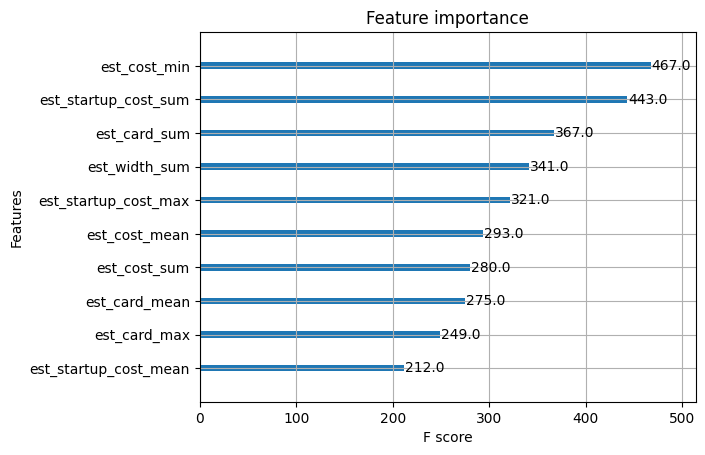

In [7]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importances
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.show()


In [8]:
import sys
sys.path.append('/home/wuy/DB/pg_mem_pred_json')
from src.training.metrics import compute_metrics
metrics = compute_metrics(y_test, y_pred)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

qerror_50 (Median): 2.1025
qerror_95: 7.6558
qerror_max: 12.2812
mean_qerror: 2.9087
mre: 1.2210
rmse: 64123.8971
